<a href="https://colab.research.google.com/github/soumyaa-physics/AI-WINTER-SCHOOL-BROWN-2025/blob/main/Unsupervised%20Learning/SelfSupervisedGalaxyFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Module for the Brown University AI Winter Workshop 2025**

CFPU, Center for the Fundamental Physics of the Universe

> https://cfpu.brown.edu/

Deptartment of Physics, Brown University

> https://physics.brown.edu

2025 Winter School Indico

> https://indico.physics.brown.edu/event/34/



In [1]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.6 MB/s eta 0:00:00


In [2]:
# Import relevant libraries
import os
import numpy as np
import pickle
import astropy
import astropy.io.fits as fits
from astropy.stats import mad_std
import umap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import split_dataset
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.regularizers import l2
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# Mount your drive - NOTE: There will be a window that will ask you to agree to access the account.  You must agree to this.
from google.colab import drive

drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Here is where we set up all the necessary paths for loading in the dataset, supervised and self-supervised models.
top_level_path = '/content/drive/Shared drives/AI Winter School (Brown Physics CFPU 2025)/'
os.listdir(top_level_path)
dataset_path = top_level_path + 'Module 4 -- Self-Supervised Learning to Find Interacting and Starburst Galaxies/train_data.pkl'
supervised_path = top_level_path + 'Module 4 -- Self-Supervised Learning to Find Interacting and Starburst Galaxies/supervised_small.keras'
finetuning_path = top_level_path + 'Module 4 -- Self-Supervised Learning to Find Interacting and Starburst Galaxies/selfsupervised_finetune.keras'
weights_path = top_level_path + 'Module 4 -- Self-Supervised Learning to Find Interacting and Starburst Galaxies/checkpoint_2.weights.h5'


In [ ]:
# Here you much set the path to your personal folder, make sure to change these paths if your local drive is set up differently.
local_drive = '/content/drive/MyDrive/'
winter_school_drive = "AI Winter School - Personal (Brown Physics CFPU 2025)/"
full_local_path = local_drive+winter_school_drive
os.listdir(full_local_path)
local_save_folder_path = full_local_path+'Module 4/'

In [ ]:
# Define the hyperparameters
bands = ['u','g', 'r', 'i', 'z'] # List of channels (in order) of the image

noise_range = [1,3] # Multiplicative range for added noise
jitter_max = 20 # Max jitter distance
CROP_TO = 128 # Size of cropped image

training_batch_size = 32 # Batch size for training dataset
val_batch_size = 16 # Batch size for validation dataset


input_shape = (200, 200, 5) # Shape of images given to the model
encoder_input_shape = (CROP_TO, CROP_TO, input_shape[2]) # Shape of images after augmentations
shuffle_buffer = 5000 # Shuffle buffer for shuffling datasets
temperature = 0.1 # Model temperature parameter
queue_size = 10000 # Number of examples in queue for self-supervised training
AUTOTUNE = tf.data.AUTOTUNE


The purpose of this module is to demonstrate the use of unsupervised/partially supervised anomaly detection as a way to identify and classify interacting galaxies.  Interacting galaxies are very important in astronomy: in addition to being sources of bursts of star formation, the additional positional and kinematic information derived from the interactions can be used to study the mass of the systems, their accretion history, and future fate.

Up until recently, anomaly detection was carried out by visual inspection.  This is actually very effective for small and medium datasets--your eye/brain combination is very effective at separating "normal" spiral galaxies




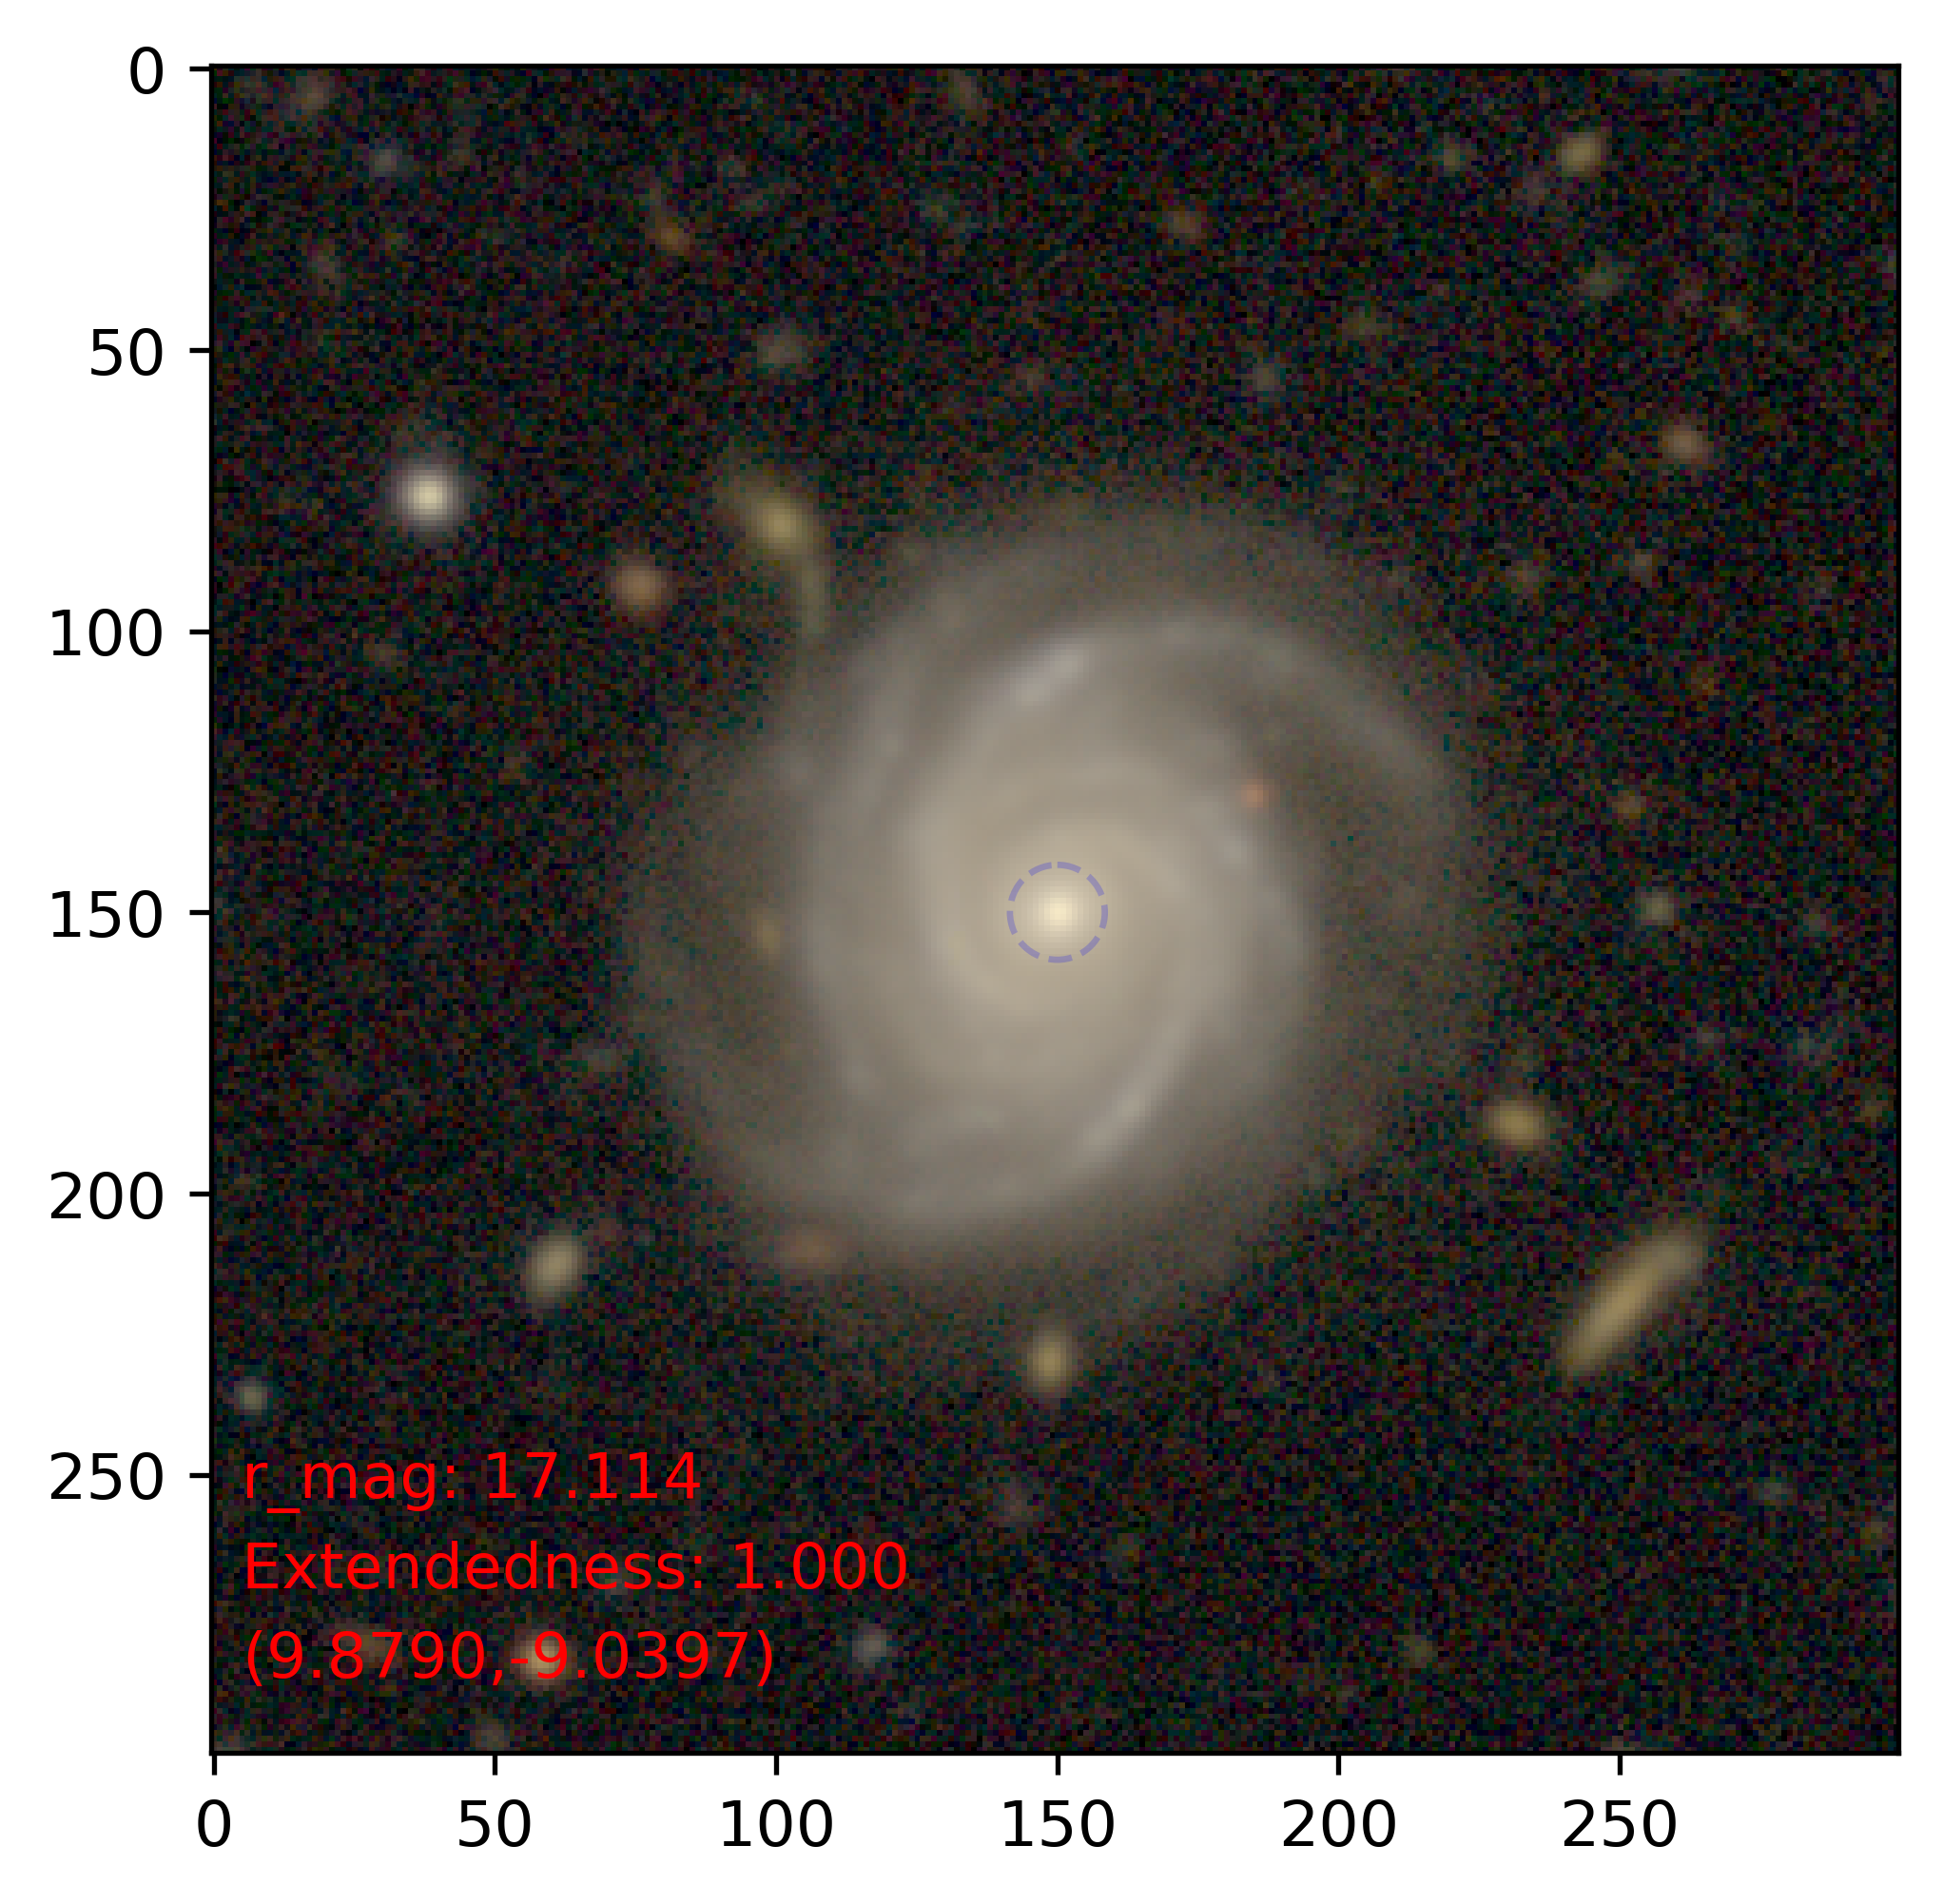

From galaxies showing disruptions due to interactions with other galaxies or the intergalactic gas.

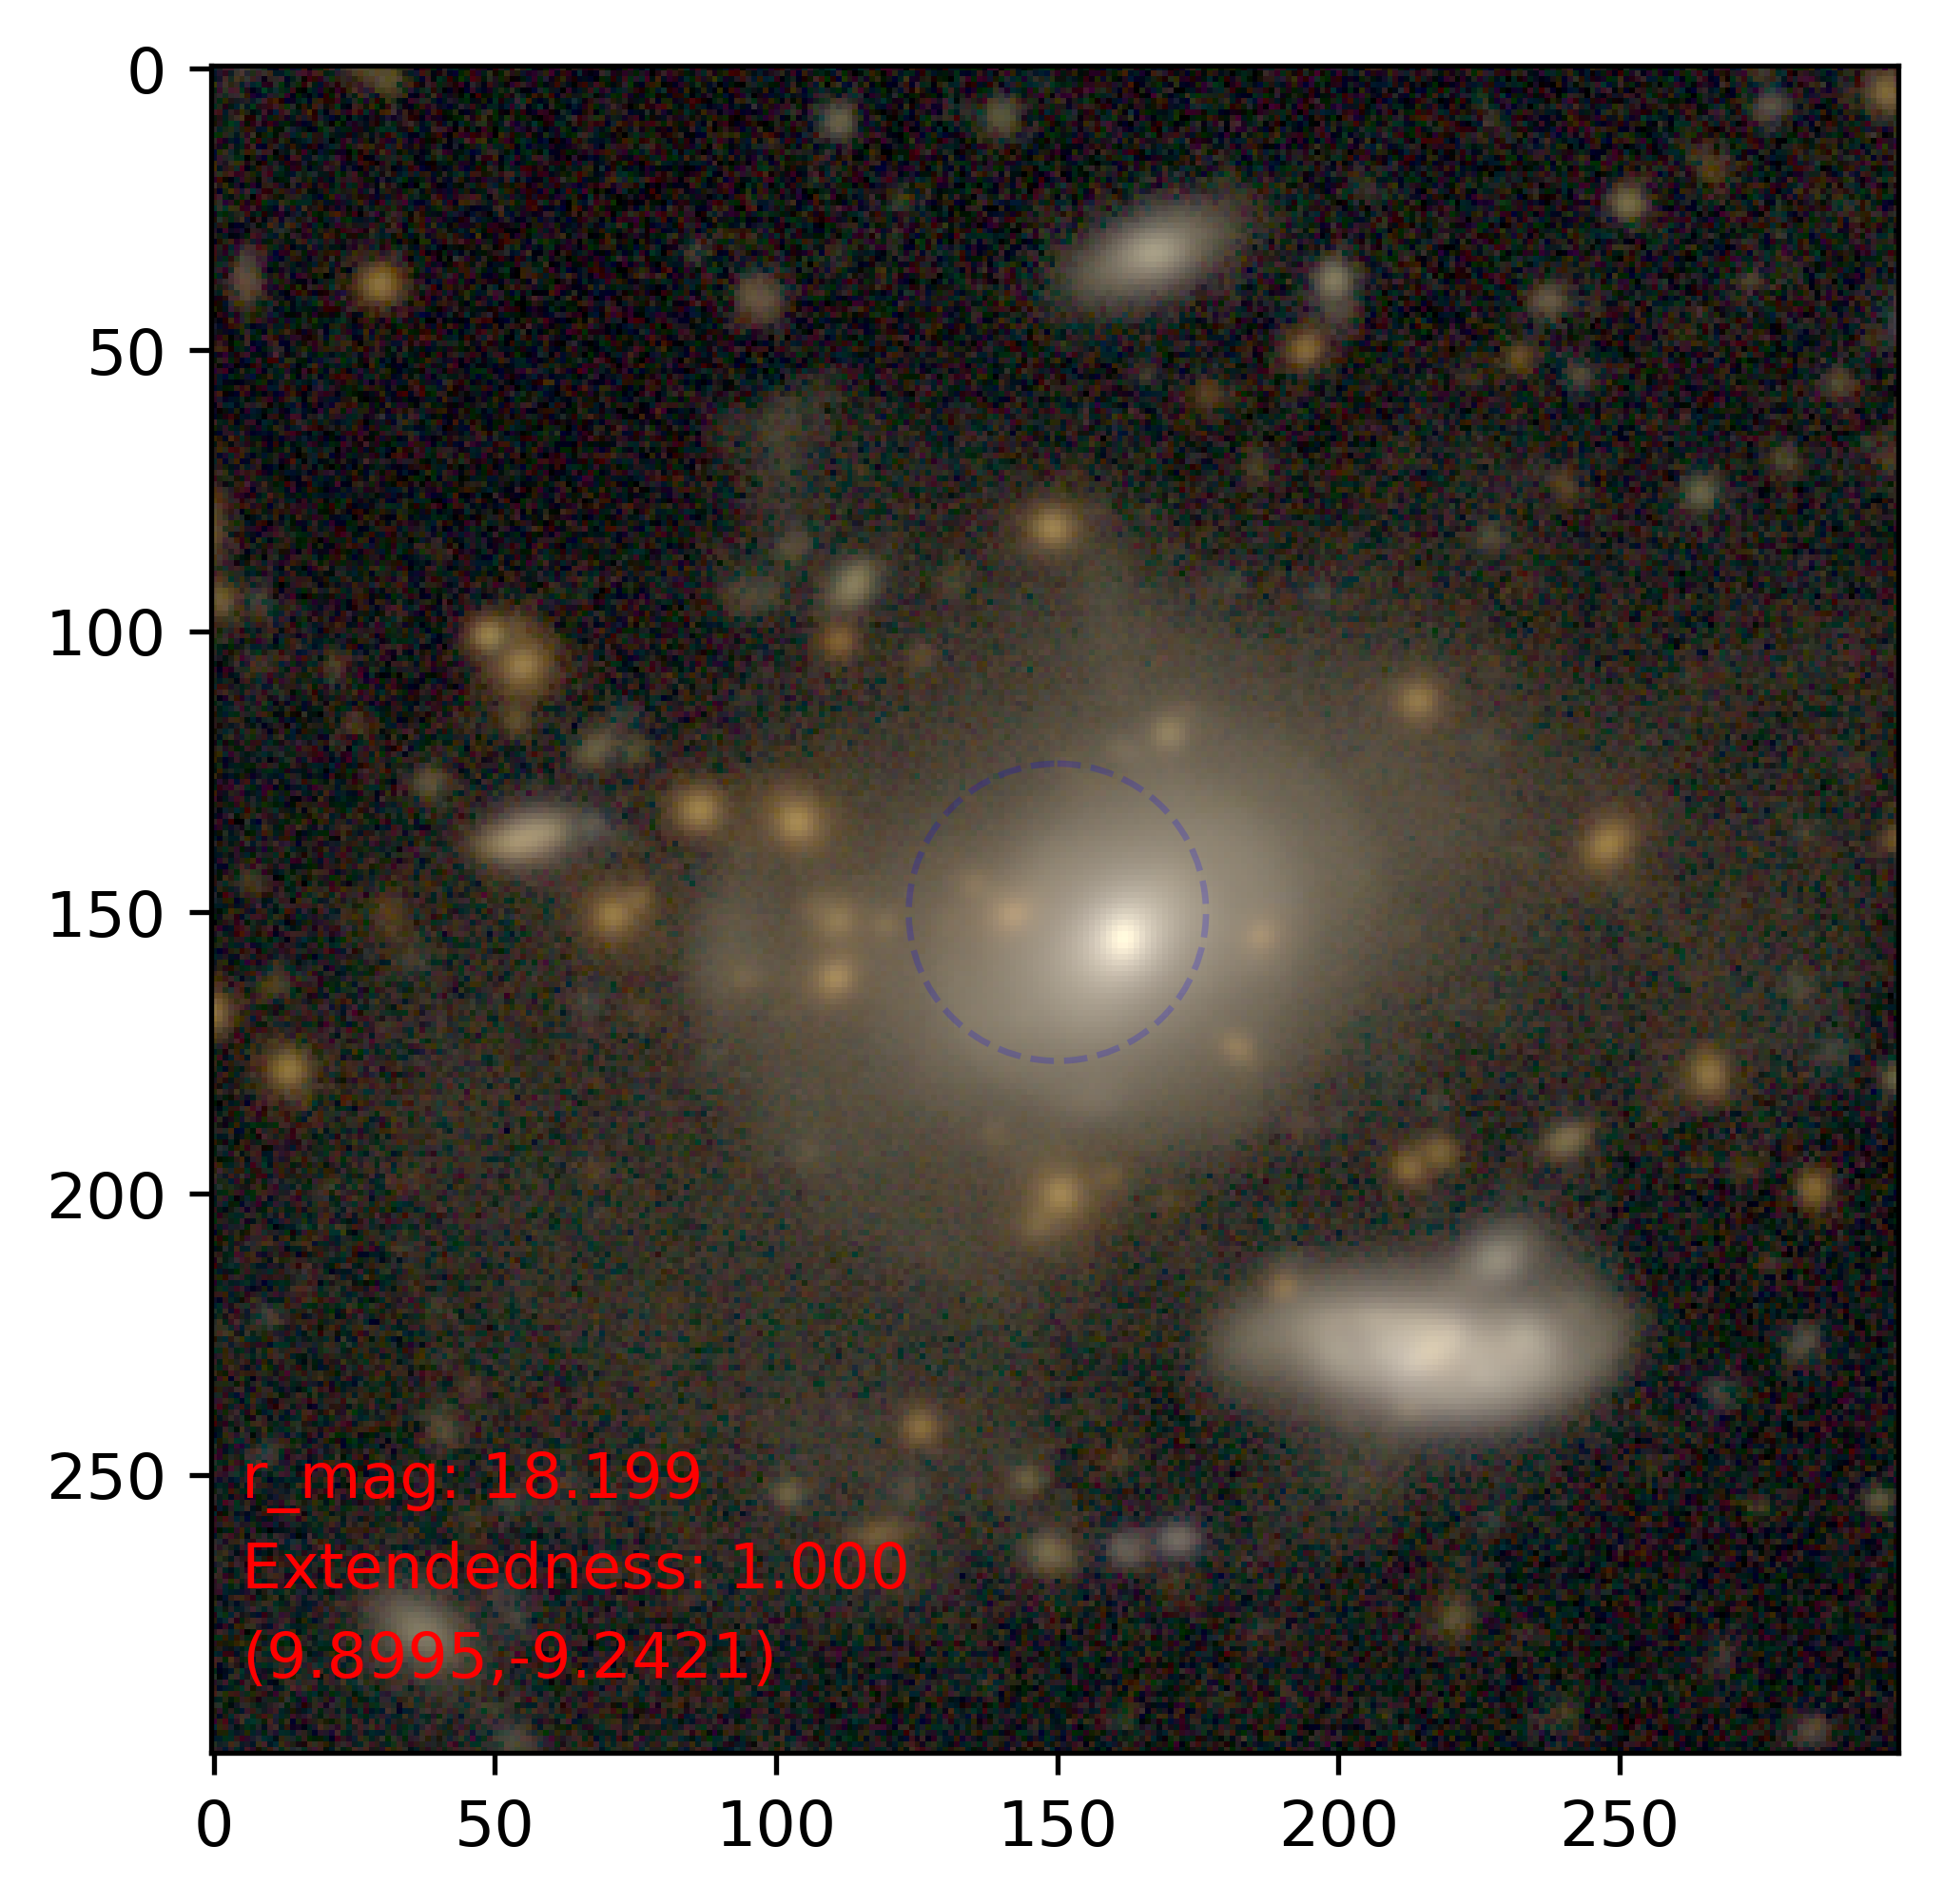


However, as datasets have gotten larger, this method has become impractical.  In the Dark Energy Survey, 500 million galaxies were imaged; the Vera Rubin Observatory's Legacy Survey of Space and Time (LSST) and the Nancy Grace Roman Telescope's High Latitdue Wide-Area Survey (HLWAS) will each measure billions of galaxies.  Even with teams of researchers or volunteers from the public, nobody will be able to look at all the galaxies.

Furthermore, having so many galaxies opens up the possibility of finding new and unusual forms of interactions.  As an example, only recently have dwarf galaxies been observed forming from the debris of galaxy interactions.  This suggests that the first step in the detection process should be self-supervised anomaly detection.  In this workshop, you'll be taking a small subset of the galaxy images from the Local Volume Complete Cluster Survey (LoVoCCS) and training a network to classify galaxies with tidal features using a labeled dataset.  You will then be analyzing a pre-trained model designed to calculate similarities between images and place them in a multi-dimensional feature space based on unlabeled data.  With this self-supervised model you will be able to visualize similarity patterns, identify isolated objects and interactively select regions of interest.  Finally, you will use your trained model and a pre-trained classification head added to self-supervised model to classify your galaxies of interest and assess the capabilities of each model.

In [ ]:
# Here we are defining the functions used for normalizing the data.
# The raw data is based on detector count rates but we want to rescale the data to help with model training.

PROJECT_DIM=128 # Dimension of an embedding vector

def find_mad_std(dataset,bands):
    '''
    Function which determines the median absolute deviation for each band in the image dataset.
    '''
    cutouts = []
    for (batch, entry) in enumerate(dataset.take(2000)):
        cutouts.append(entry)
    cutouts = np.stack(cutouts)
    scaling = []
    for i, b in enumerate(bands):
        sigma = mad_std(cutouts[..., i].flatten())
        scaling.append(sigma)

    return scaling

def normalization(example,scale):
    '''
    Function which normalizes the data using an inverse hyperbolic sine.
    '''
    img = example
    img = tf.math.asinh(tf.cast(img, tf.float32) / tf.constant(scale) / 3.)
    return img

With the functions for normalization defined, we start by loading in the data which will be used for training and validating the model. The data consists of 918 images with their associated labels, 1 indicating that the galaxy contains a tidal feature and 0 if the galaxy does not. The data is separated into two sets, one for training and one for validation, using an 80/20 split. The data is then shuffled and batched so it is ready to be given to the models.

In [ ]:
with open(dataset_path, 'rb') as f:
    images, labels = pickle.load(f)
dset = tf.data.Dataset.from_tensor_slices((images,labels))
scale = find_mad_std(dset.map(lambda image, label: image),bands = bands)
dset = dset.map(lambda image, label: (normalization(image, scale), label))
dset = dset.shuffle(buffer_size=shuffle_buffer,reshuffle_each_iteration=False)
train_size = int(0.8 * len(dset))
tset = dset.take(train_size)
vset = dset.skip(train_size)
dset_label = dset.map(lambda image, label: label)
dset = dset.map(lambda image, label: image)
dset_label = dset_label.batch(training_batch_size, drop_remainder=True)
dset = dset.batch(training_batch_size, drop_remainder=True)
tset = tset.shuffle(buffer_size=shuffle_buffer).batch(training_batch_size, drop_remainder=True)
vset = vset.shuffle(buffer_size=shuffle_buffer,reshuffle_each_iteration=False).batch(val_batch_size, drop_remainder=True)


Now that the data is prepared, we must define the augmentations we wish to apply to the raw data as it is passed through our neural networks. The augmentor is build using a keras Sequential object which will cooperate nicely with our batched dataset and automatically augment the images during training. This is important since we want randomly augmented images during each training step, an especially necessary measure when training the self-supervised network since it relies on comparing two randomly augmented images.

In [ ]:
class RandomGaussianNoise(layers.Layer):
    '''
    Layer used in the data augmentation process which adds random gaussian noise to the input image.
    '''
    def __init__(self, scale, noise_range):
        super().__init__()
        self.scale = scale
        self.noise_range = noise_range

    def call(self, images, training=False):
        sigma = tf.random.uniform([], minval = self.noise_range[0], maxval = self.noise_range[1])
        images += sigma * self.scale * tf.random.normal(tf.shape(images))
        return images

class RandomResizedCrop(layers.Layer):
    '''
    Layer which crops the input image to the desired size and randomly jitters
    the central position adding a translation to the output image.
    '''
    def __init__(self, scale, jitter_max,CROP_TO):
        super().__init__()
        self.scale = scale
        self.PRE_CROP = CROP_TO+jitter_max
        self.CROP_TO = CROP_TO

    def call(self, images):
        batch_size = tf.shape(images)[0]
        im_height = tf.shape(images)[1]
        im_channels = tf.shape(images)[3]
        images = tf.image.central_crop(images,self.PRE_CROP/im_height)
        images = tf.image.random_crop(images, (batch_size,self.CROP_TO, self.CROP_TO, im_channels))
        return images

def augmentor(input_shape, scale, noise_range, jitter_max, CROP_TO):
    '''
    The augmentor is used to apply the desired augmentation to the raw data
    preparing it for input to the model. The augmentations include randomly
    flipping the image both vertically and horizontally, adding gaussian noise
    to the image, and cropping and translating the image.
    '''
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.RandomFlip(mode="horizontal_and_vertical"),
            RandomGaussianNoise(scale = scale, noise_range=noise_range),
            RandomResizedCrop(scale=scale, jitter_max=jitter_max, CROP_TO = CROP_TO),
        ]
    )

Lets take a look at the augmented data! Since the data has 5 bands, we need to convert it into a 3 band RGB image in order for it to be displayed. Notice how the augmented images have varying levels of noise, orientation, and jitter. Adding noise to the augmented images is important in order to have trained models be robust to varying levels of noise inherent to telescope data. The images are flipped in order to not have the model depend on the orientation of a galaxy which is inherrently random. Finally, the images are cropped and jittered to add a translational invariance to the model so the positioning of the galaxy is not a deciding factor.

In [ ]:
data_set = np.stack(list(dset)).reshape(-1,200,200,5)
label_set = np.stack(list(dset_label)).reshape(-1,1)
aug_seq = augmentor(input_shape, scale, noise_range, jitter_max, CROP_TO)
aug = []
for image_batch in dset.take(1):
    aug.append(aug_seq.call(image_batch, training=True))
aug = np.concatenate(aug, axis=0)

aug_rgb = aug[..., :3]
aug_rgb[...,0] = (aug[...,3] + aug[...,4])/2
aug_rgb[...,1] = aug[...,2]
aug_rgb[...,2] = aug[...,1]

data_rgb = data_set[..., :3]
data_rgb[...,0] = (data_set[...,3] + data_set[...,4])/2
data_rgb[...,1] = data_set[...,2]
data_rgb[...,2] = data_set[...,1]

num_images = 3
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 4))

for i in range(num_images):
    image = data_rgb[i]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    aug_temp = aug_rgb[i]
    aug_temp = (aug_temp - np.min(aug_temp)) / (np.max(aug_temp) - np.min(aug_temp))
    axes[i, 1].imshow(aug_temp)
    axes[i, 1].set_title('Augmented Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

With the augmentations ready, we now need to define the supervised model architecture. This is a convolutional model meaning it reduces the size of the images using convolutional and pooling layers before flattening the image data and passing it through dense layers. The sigmoid activation function is used at the end in order to have the model output follow a binary classification.

In [ ]:
class Supervised(keras.Model):
    '''
    Supervised convolutional model trained to classify the existance of tidal features in galaxies.
    '''
    def __init__(self,input_shape,encoder_input_shape, scale, noise_range, jitter_max, CROP_TO):
        super().__init__()
        self.contrastive_augmentor = augmentor(input_shape, scale, noise_range, jitter_max, CROP_TO)
        self.mlp_model = keras.Sequential([
            layers.Input(shape=encoder_input_shape),
            layers.Conv2D(32, (6, 6), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dropout(0.2),
            layers.MaxPool2D(),
            layers.Conv2D(64, (5, 5), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dropout(0.2),
            layers.MaxPool2D(),
            layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dropout(0.2),
            layers.MaxPool2D(),
            layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dropout(0.2),
            layers.MaxPool2D(),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid')
        ], name='mlp_model')

    def call(self, images, training=False):
        augmented_images = self.contrastive_augmentor(images)
        return self.mlp_model(augmented_images)

**WARNING This step will take ~ 10 minutes to run**

Since we are currently limited to CPUs for the Google Colab Notebooks, we will load in the pre-trained weights for the supervised model. We will then run training for only 5 steps in order to demonstrate the training process. The model uses the adam optimizer to update its weights and uses binary cross-entropy as the loss function for the binary classification task of deciding between tidal feature or no tidal feature. In the model summary you can see the weights and shapes associated with each layer of the network, notice how the size of the images gets smaller as it goes deeper into the network.

In [ ]:
sup_model = Supervised(input_shape = input_shape,
              encoder_input_shape = encoder_input_shape,
              scale = scale,
              noise_range = noise_range,
              jitter_max = jitter_max,
              CROP_TO = CROP_TO
              )

sup_model.mlp_model = keras.models.load_model(supervised_path)
sup_model.summary()
sup_model.mlp_model.summary()

sup_model.compile(optimizer='adam',loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy(name="acc")])

sup_model_history = sup_model.fit(tset, epochs=5, validation_data = vset)

In [ ]:
plt.plot(sup_model_history.history['loss'], label='Training Loss')
plt.plot(sup_model_history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Summary of Training - Loss')
plt.legend()

In [ ]:
plt.plot(sup_model_history.history['acc'], label='Training Accuracy')
plt.plot(sup_model_history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Summary of Training - Accuracy')
plt.legend()

With the supervised model having traing, we will now shift focus to the self-supervised model. Here is a visual description of the self-supervised architecture from Desmons et al.

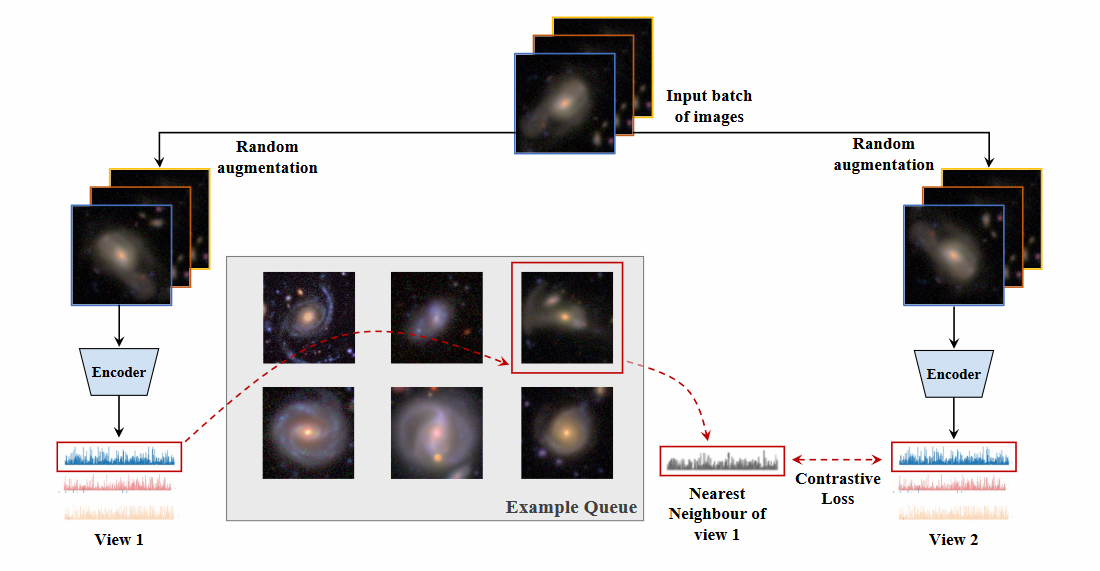

In this model, each input image is turned into to seperatly augmented images. These images are then passed through a convolutional neural network which encodes then into an embedding space vector. These embeddings are then compared to all other samples in the dataset and the nearest neighbors for each embedding are used in a four way contrastive loss which attempts to minimize the distance between the embeddings and their nearest neighbors. This will allows the model to develop groupings within the dataset despite the training data lacking labels.

In [ ]:
## Define NNCRL Self-supervised network
def stem(inputs):
    x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', use_bias=False,
                    kernel_regularizer=l2(0.0005))(inputs)
    x = layers.BatchNormalization(gamma_regularizer=l2(0.0005), beta_regularizer=l2(0.0005))(x)
    x = layers.ReLU()(x)
    return x

def learner(x):
    x = stack_residual_blocks_v1(x, 32, 3, stride1=1)
    x = stack_residual_blocks_v1(x, 64, 4)
    x = stack_residual_blocks_v1(x, 128, 6)
    return stack_residual_blocks_v1(x, 256, 3)

def stack_residual_blocks_v1(x, filters, blocks, stride1=2, name=None):
    x = residual_block_v1(x, filters, stride=stride1, name=name)
    for i in range(2, blocks + 1):
        x = residual_block_v1(x, filters, conv_shortcut=False)
    return x

def residual_block_v1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    if conv_shortcut:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, use_bias=False)(x)
    else:
        shortcut = x

    x = layers.BatchNormalization(gamma_regularizer=l2(0.0005), beta_regularizer=l2(0.0005))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 1, strides=stride, use_bias=False,kernel_regularizer=l2(0.0005), name=name)(x)

    x = layers.BatchNormalization(gamma_regularizer=l2(0.0005), beta_regularizer=l2(0.0005))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding="SAME",kernel_regularizer=l2(0.0005), use_bias=False)(x)

    x = layers.BatchNormalization(gamma_regularizer=l2(0.0005), beta_regularizer=l2(0.0005))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(4 * filters, 1, kernel_regularizer=l2(0.0005),use_bias=False)(x)

    x = layers.Add()([shortcut, x])
    return x

def encoder(input_shape):
    inputs = layers.Input(input_shape)
    x = stem(inputs)
    x = learner(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(PROJECT_DIM, use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(PROJECT_DIM, use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name='encoder')

class NNCLR(keras.Model):
    def __init__(self, input_shape, encoder_input_shape, temperature, queue_size,
                 scale, noise_range, jitter_max, CROP_TO):
        """
        Self-supervised model which augments and encodes images and calculates the contranstive loss.
        """
        super().__init__()
        # Define metrics
        self.correlation_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        # Define augmentor
        self.contrastive_augmentor = augmentor(input_shape, scale, noise_range, jitter_max, CROP_TO)

        # Define model structure
        self.encoder = encoder(encoder_input_shape)
        self.projection_head = keras.Sequential(
            [
                layers.Input(shape=(PROJECT_DIM,)),
                layers.Dense(PROJECT_DIM, activation='relu'),
                layers.Dense(PROJECT_DIM),
            ],
            name="projection_head"
        )
        self.temperature = temperature

        # Initialise the support set that will be used to find nearest
        # neighbours
        self.feature_queue = tf.Variable(
            tf.math.l2_normalize(
                tf.random.normal(shape=(queue_size, PROJECT_DIM)), axis=1
            ),
            trainable=False
        )

    def compile(self, contrastive_optimizer, **kwargs):
        super().compile(**kwargs)
        self.contrastive_optimizer = contrastive_optimizer

    def nearest_neighbour(self, projections):
        support_similarities = tf.matmul(projections, self.feature_queue, transpose_b=True)
        nn_projections = tf.gather(self.feature_queue, tf.argmax(support_similarities, axis=1), axis=0)

        return projections + tf.stop_gradient(nn_projections - projections)

    def update_contrastive_accuracy(self, features_1, features_2):
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)

        similarities = tf.matmul(features_1, features_2, transpose_b=True)
        batch_size = tf.shape(features_1)[0]

        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0)
        )

    def update_correlation_accuracy(self, features_1, features_2):

        features_1 = (features_1 - tf.reduce_mean(features_1, axis=0)) / tf.math.reduce_std(features_1, axis=0)
        features_2 = (features_2 - tf.reduce_mean(features_2, axis=0)) / tf.math.reduce_std(features_2, axis=0)
        batch_size = tf.cast(tf.shape(features_1)[0], tf.float32)
        cross_correlation = (tf.matmul(features_1, features_2, transpose_a=True) / batch_size)

        feature_dim = tf.shape(features_1)[1]
        correlation_labels = tf.range(feature_dim)
        self.correlation_accuracy.update_state(
            tf.concat([correlation_labels, correlation_labels], axis=0),
            tf.concat([cross_correlation, tf.transpose(cross_correlation)], axis=0)
        )

    def contrastive_loss(self, projections_1, projections_2):
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)

        # Calculate cosine similarities (scaled by temperature) of:
        # - nearest neighbour of projection_1 to projection_2
        # - projection_2 to nearest neighbour of projection_1
        # - nearest neighbour of projection_2 to projection_1
        # - projection_1 to nearest neighbour of projection_2
        similarities_1_2_1 = (tf.matmul(self.nearest_neighbour(projections_1), projections_2, transpose_b=True)/ self.temperature)

        similarities_1_2_2 = (tf.matmul(projections_2, self.nearest_neighbour(projections_1), transpose_b=True)/ self.temperature)

        similarities_2_1_1 = (tf.matmul(self.nearest_neighbour(projections_2), projections_1, transpose_b=True)/ self.temperature)

        similarities_2_1_2 = (tf.matmul(projections_1, self.nearest_neighbour(projections_2), transpose_b=True)/ self.temperature)

        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            tf.concat(
                [
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels
                ],
                axis=0
            ),
            tf.concat(
                [
                    similarities_1_2_1,
                    similarities_1_2_2,
                    similarities_2_1_1,
                    similarities_2_1_2,
                ],
                axis=0
            ),
            from_logits=True
        )

        # Update the feature queue
        self.feature_queue.assign(tf.concat([projections_1, self.feature_queue[:-batch_size]], axis=0))
        return loss

    def train_step(self, images):
        # Get the augmented images
        augmented_images_1 = self.contrastive_augmentor(images)
        augmented_images_2 = self.contrastive_augmentor(images)

        # Pass through the model and calculate the loss
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)

        # Calculate gradients and backpropagate
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights
            )
        )

        # Update accuracy metrics
        self.update_contrastive_accuracy(features_1, features_2)
        self.update_correlation_accuracy(features_1, features_2)

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
            "r_acc": self.correlation_accuracy.result()
        }

**WARNING This step will take ~6 minutes to run**

Since self-supervised training is done with extremely large amounts of data, we will be loading in a pre-trained model to evaluate. We will use the encoder portion of the model to determine the embeddings for each of the images in our dataset. Using these embeddings we can explore the embedding space and gain insight into the features being grouped together.

In [ ]:
model = NNCLR(input_shape = input_shape,
              encoder_input_shape = encoder_input_shape,
              temperature = temperature,
              queue_size = queue_size,
              scale = scale,
              noise_range = noise_range,
              jitter_max = jitter_max,
              CROP_TO = CROP_TO
              )

model.load_weights(weights_path)
model.compile(contrastive_optimizer=keras.optimizers.Adam())
aug = model.contrastive_augmentor.predict(dset)
embs = model.encoder.predict(aug)

Since the embedding space is 128 dimensional, we can use UMAP to project the embeddings into 2 dimensions. This will allow us to easily graph the embedding space and analyse the results.

In [ ]:
reducer = umap.UMAP(n_components=2)
embeddings_2d = reducer.fit_transform(embs)

Before looking into the embeddings, we will quickly define the classification head added to the self-supervised encoder which is used to make classification. The addition to the model consists of dense layers which take the embeddings as an input and ouputs binary classifications similar to the supervised model. To train the classification head, the model is fine-tuned with labeled data after the self-supervised training. Since this is also a lengthy process, we will be loading in the pre-trained model.

In [ ]:
class Finetuning(keras.Model):
    '''
    Self-supervised encoder with classification head added to the end. The
    model is fine-tuned using the labeled dataset.
    '''
    def __init__(self,input_shape,encoder_input_shape, scale, noise_range, jitter_max, CROP_TO, encoder):
        super().__init__()
        self.contrastive_augmentor = augmentor(input_shape, scale, noise_range, jitter_max, CROP_TO)
        self.model_encoder = encoder
        self.fine_model = keras.Sequential([
            layers.Input(shape=(128,)),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid')
        ], name='fine_model')

    def call(self, images, training=False):
        augmented_images = self.contrastive_augmentor(images)
        embeds = self.model_encoder(augmented_images)
        return self.fine_model(embeds)

finetuning_model = Finetuning(input_shape = input_shape,
              encoder_input_shape = encoder_input_shape,
              scale = scale,
              noise_range = noise_range,
              jitter_max = jitter_max,
              CROP_TO = CROP_TO,
              encoder = model.encoder
              )
finetuning_model.fine_model = keras.models.load_model(finetuning_path)
finetuning_model.compile(optimizer=keras.optimizers.Adam(),
                            loss=keras.losses.BinaryCrossentropy(),
                            metrics=[keras.metrics.BinaryAccuracy(name="acc")])

finetuning_model.summary()

Now that all of our models are ready we can begin to explore the embedding space. The first two variables in the cell represent a coordinate you choose in the embedding space. The four nearest galaxies to that coordinate will then be displayed next to the projected embedding space. Take a look around the embedding space and see what you can determine about the model's groupings. When you find a group of galaxies you think are the most interesting proceed with the next cells. You can re-run this cell with new x and y coordinates to test different locations in the embedding space.

**IMPORTANT Make sure to re-run this cell until you are satisfied with your chosen galaxies, the resulting image will be part of the module submission**

In [ ]:
########### COORDINATES TO CHANGE ################

x_val = 7
y_val = 8

##################################################

fig_main = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 4)
ax1 = fig_main.add_subplot(gs[0:2, 0:2])
ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=0.5)
ax1.scatter(x_val,y_val)
ax1.set_title('Embedding Space')
ax2 = fig_main.add_subplot(gs[0, 2])
ax3 = fig_main.add_subplot(gs[0, 3])
ax4 = fig_main.add_subplot(gs[1, 2])
ax5 = fig_main.add_subplot(gs[1, 3])
distances = np.linalg.norm(embeddings_2d - (x_val,y_val), axis=1)
closest_indices = np.argsort(distances)[:4]

num_images = 4
for i, ax in enumerate([ax2, ax3, ax4, ax5]):
    image = data_rgb[closest_indices[i]]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    ax.imshow(image)
    ax.set_title(f'Classification: {label_set[closest_indices[i]][0]}')
    if (1 == label_set[closest_indices[i]][0]):
        ax.add_patch(patches.Rectangle((0, 0), image.shape[1], image.shape[0],
                        linewidth=6, edgecolor='lime', facecolor='none'))
    else:
        ax.add_patch(patches.Rectangle((0, 0), image.shape[1], image.shape[0],
                        linewidth=7, edgecolor='red', facecolor='none'))
    ax.axis('off')
plt.tight_layout()
plt.savefig(local_save_folder_path +'module_4_evaluation_'+last_name+'_'+first_name+'_Brown_winter_school_'+date+'.png', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()
chosen_labels = label_set[closest_indices].flatten()


Now that you have chosen your desired galaxies, we will use the supervised and self-supervised models to make classifications. The following cell will querey the models and print out the model accuracy.

**Note these values since they will be part of the module submission**

In [ ]:
testing_data = tf.data.Dataset.from_tensor_slices((data_set[closest_indices], label_set[closest_indices].flatten()))
testing_data = testing_data.map(lambda images, label: (images, label))
acc_sup = tf.keras.metrics.BinaryAccuracy()
acc_self = tf.keras.metrics.BinaryAccuracy()
preds_sup = []
preds_self = []
for data, labs in testing_data.batch(4):
    pred = sup_model(data, training=False)
    pred2 = finetuning_model(data, training=True)
    acc_sup.update_state(labs, pred)
    acc_self.update_state(labs, pred2)
    preds_sup.append(pred.numpy())
    preds_self.append(pred2)

preds_sup = np.array(preds_sup[0]).flatten()
preds_self = np.array(preds_self[0]).flatten()
print("Supervised Model Accuracy: ", acc_sup.result().numpy())
# print(np.array(preds_sup[0]))
print("Self-Supervised Model Accuracy: ", acc_self.result().numpy())
# print(preds_self)

Finally, lets plot the images with their respective classifications to see how the models did! Green means the model predicted a tidal feature while red indicates no tidal feature. Note that these models are trained with a small fraction of the LoVoCCS survey and don't have high accuracy. Don't feel bad if the models are making incorrect predictions.

In [ ]:
def plot_preds(input_pred, model):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2.5))
    for i in range(len(closest_indices)):
        image = data_rgb[closest_indices[i]]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        axes[i].imshow(image)
        if (1 == round(input_pred[i])):
            axes[i].add_patch(patches.Rectangle((0, 0), image.shape[1], image.shape[0],
                            linewidth=6, edgecolor='lime', facecolor='none'))
        else:
            axes[i].add_patch(patches.Rectangle((0, 0), image.shape[1], image.shape[0],
                            linewidth=7, edgecolor='red', facecolor='none'))

        axes[i].axis('off')

    fig.suptitle(model, fontsize=16)
    plt.tight_layout()
    plt.show()


plot_preds(chosen_labels, "True Classifications")
plot_preds(preds_sup, "Supervised Model Classifications")
plot_preds(preds_self, "Self-Supervised Model Classifications")

Congratulations!! You are done with module 4! We hope you learned some new things about astrophysics and machine learning and had fun during the process!